In [63]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [64]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader  # Load the data
from torch.utils.tensorboard import SummaryWriter  # Show the Tensorboard
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
import random
import numpy as np
from math import ceil

In [65]:
print(torch.cuda.is_available())

True


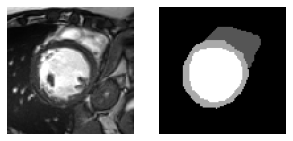

True

In [66]:
def show_image_mask(img, mask, cmap='gray'):  # visualisation
    fig = plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
data_dir = '/content/drive/My Drive/data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

# **1 DataImport**

In [67]:
################################################################################
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root, 'mask', basename[:-4] + '_mask.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)


class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)
################################################################################

# **2 CNN Structure**

In [68]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=1, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

# **4 Functions of Training, Validation**

## Parameter Setting

In [86]:
# Network Established 
net = NestedUNet(num_classes=4).cuda()


# The Hyperparameter that Optimized
batchsize=4
learningrate=1e-5



# Using decreaseing learning rate tuning
from torch.optim.lr_scheduler import ReduceLROnPlateau
min_learningrate=1e-12
lr_patience=10


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
best_val_loss = 0.08

#RMSprop(net.parameters(), lr=learningrate, weight_decay=1e-8, momentum=0.9)




# Data Load
train_data_path = '/content/drive/My Drive/data/train'
train_set = TrainDataset(train_data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=batchsize, shuffle=True)
valid_data_path = '/content/drive/My Drive/data/val'
valid_set = TrainDataset(valid_data_path)
valid_data_loader = DataLoader(dataset=valid_set, num_workers=4, batch_size=batchsize, shuffle=False)

model_data_path = '/content/drive/My Drive/data/model'

writer_path = os.path.join(model_data_path,'NestedUNet/log')
# Record training process ( basically for ploting figure )
writer = SummaryWriter(writer_path)

## AverageMeter and Validation Func

In [87]:
# Calculate average value of current batch
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


####
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask.cpu().numpy()].cpu().numpy().astype(int)+
        label_pred[mask.cpu().numpy()], 
        minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

###
def evaluate(predictions, gts, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(predictions, gts):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    # axis 0: gt, axis 1: prediction
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

## Training Sec

In [88]:
def train(training_data_loader, net, loss_function, optimizer,epoch):
  # Change model status as Training Mode
    net.train()
    train_loss = AverageMeter()
    curr_iter = (epoch - 1) * len(training_data_loader)
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.cuda()

        N = img.size(0)           # number of batch
        optimizer.zero_grad()     # CLEAR GRADIENT BUFFER
        outputs = net(img)        # FORWARD
        loss = loss_function(outputs, mask.to(dtype=torch.int64)) / N # mask type need to be long
        loss.backward()           # BACKWORD
        optimizer.step()          # UPDATE GRADIENT

        train_loss.update(loss.data.item(),N) # Average loss of this loop
        curr_iter += 1
        writer.add_scalar('train_loss', train_loss.avg, curr_iter)

        if (iteration + 1) % 10 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                  epoch+1, iteration + 1, len(training_data_loader), train_loss.avg
        ))
    return train_loss.avg

## Validation sec

In [89]:
def validation(valid_data_loader, net, loss_function, optimizer, epoch):
    # Model Status as Evaluation Mode
    net.eval()
    val_loss = AverageMeter()
    img_all, mask_all, predictions_all = [], [], []

    for iteration, sample in enumerate(valid_data_loader): 
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

        N = img.size(0)           # number of data
        outputs = net(img)        # FORWARD
        # Take max over 1D, return [[max of each row], [index of each max]]
        # Get the Max values index
        predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy() 

        val_loss.update(loss_function(outputs, mask).data.item()/ N, N)
        
        with torch.no_grad():
            mask.squeeze_(0).cpu().numpy()
        mask_all.append(mask)
        predictions_all.append(predictions)
    # Accuracy, Accuracy of each columns , Mean IU, Frequency Weighted Intersection
    # Acc = Correct/Totall
    # Acc_cls = Accuracy of each class
    # IU is Recall, Mean_IU is mean Recall
    # Fwavacc is frequency times Recall
    acc, acc_cls, mean_iu, fwavacc = evaluate(predictions_all, mask_all, 4)# Number of class=4

    writer.add_scalar('val_loss', val_loss.avg, epoch)
    writer.add_scalar('acc', acc, epoch)
    writer.add_scalar('acc_cls', acc_cls, epoch)
    writer.add_scalar('mean_iu', mean_iu, epoch)
    writer.add_scalar('fwavacc', fwavacc, epoch)
    #writer.add_scalar('lr', optimizer.param_groups[1]['lr'], epoch)
    
    print('====================================================================')
    print('[epoch %d], [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f]' % (
        epoch+1, val_loss.avg, acc, acc_cls, mean_iu, fwavacc))
    print('====================================================================')

    return val_loss.avg

# **5 Training and validating**

In [90]:
# Epochs
epochs=600


#Training and Validation
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=lr_patience, min_lr=min_learningrate, verbose=True)# With Learning Decreasing
for epoch in range(epochs):
    PATH = os.path.join(model_data_path, 'NestedUNet/Bestmodel_epoch_'+ str(epoch)+'.pth')
    train_loss = train(training_data_loader, net, loss_function, optimizer,epoch)
    val_loss = validation(valid_data_loader, net, loss_function, optimizer, epoch)
    # Draw train val map
    writer.add_scalars('train/val loss', {
                                        'train_loss':train_loss,
                                        'val_loss':val_loss}, epoch)
    # Save the best model
    if val_loss < best_val_loss:
        print(f"Model Saved at {PATH}")
        best_val_loss = val_loss
        torch.save(net.state_dict(), PATH)
    scheduler.step(val_loss)

[epoch 1], [iter 10 / 25], [train loss 0.35222]
[epoch 1], [iter 20 / 25], [train loss 0.34521]
[epoch 1], [val loss 0.38363], [acc 0.05316], [acc_cls 0.25296], [mean_iu 0.04414], [fwavacc 0.01070]
[epoch 2], [iter 10 / 25], [train loss 0.31877]
[epoch 2], [iter 20 / 25], [train loss 0.31377]
[epoch 2], [val loss 0.32294], [acc 0.46750], [acc_cls 0.53163], [mean_iu 0.21833], [fwavacc 0.39435]
[epoch 3], [iter 10 / 25], [train loss 0.29552]
[epoch 3], [iter 20 / 25], [train loss 0.29004]
[epoch 3], [val loss 0.29862], [acc 0.57395], [acc_cls 0.64605], [mean_iu 0.29053], [fwavacc 0.49093]
[epoch 4], [iter 10 / 25], [train loss 0.27219]
[epoch 4], [iter 20 / 25], [train loss 0.27172]
[epoch 4], [val loss 0.27795], [acc 0.67115], [acc_cls 0.70685], [mean_iu 0.36604], [fwavacc 0.59108]
[epoch 5], [iter 10 / 25], [train loss 0.26441]
[epoch 5], [iter 20 / 25], [train loss 0.25982]
[epoch 5], [val loss 0.27069], [acc 0.72002], [acc_cls 0.76494], [mean_iu 0.41496], [fwavacc 0.63804]
[epoch 6],

In [ ]:
! tensorboard --logdir=writer_path --host localhost --port 8088

2020-12-17 17:01:56.793448: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.3.0 at http://localhost:8088/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.6/concurrent/futures/thread.py", line 33, in _python_exit
    def _python_exit():
KeyboardInterrupt


# Testing

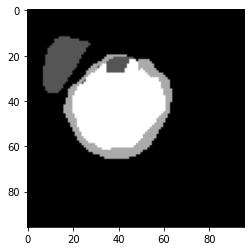

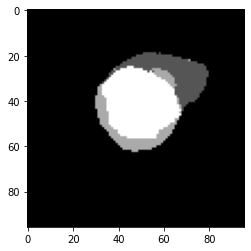

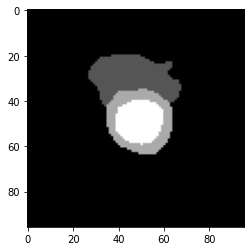

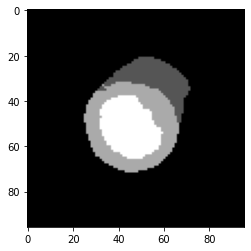

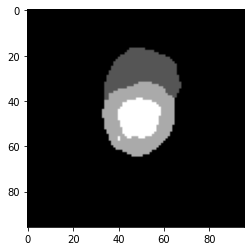

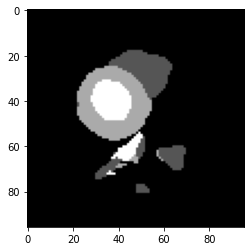

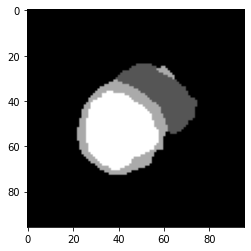

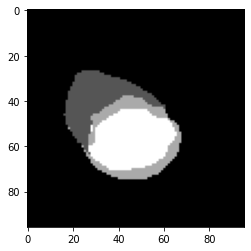

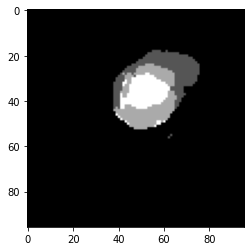

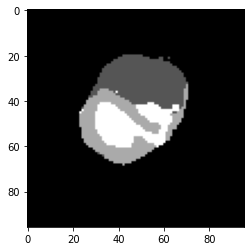

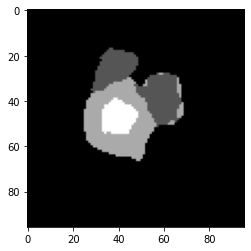

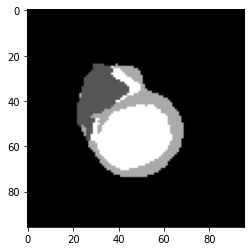

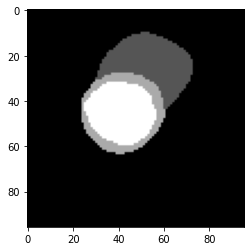

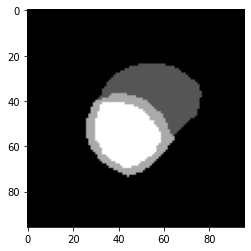

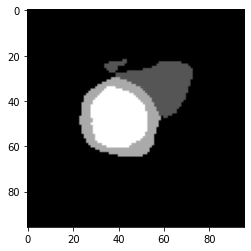

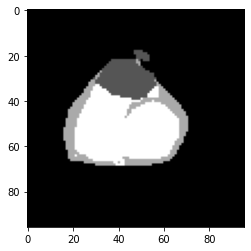

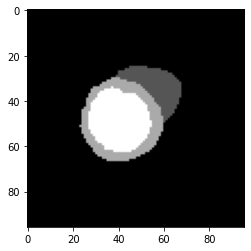

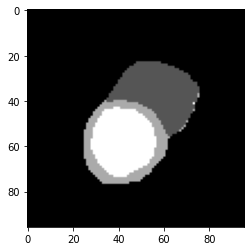

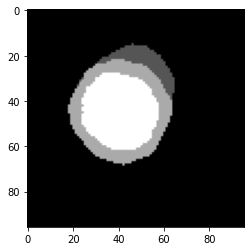

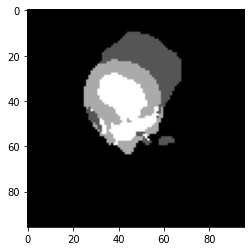

In [91]:
test_data_path = '/content/drive/My Drive/data/test'
test_set = TestDataset(test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=4, batch_size=batchsize, shuffle=False)
PATH = os.path.join(model_data_path,'NestedUNet', 'Bestmodel_epoch_450'+'.pth')
net = NestedUNet(num_classes=4).cuda()
net.load_state_dict(torch.load(PATH))
net.eval()
val_loss = AverageMeter()
batchsize=4
learningrate=1e-5


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


for iteration, sample in enumerate(test_data_loader):
    img= sample
    img=img.unsqueeze(1).cuda() # adding 1 channel
    #mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

    outputs = net(img)
    predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
    plt.imshow(predictions[0,...],cmap='gray')
    plt.pause(0.1)